In [5]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import scipy as sp
import random
import matplotlib
import time
import fct_setup as setup
import fct_general as fct
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

setup.SetPlotParams()


In [6]:
def simulate_current(matrix, I, T, x0, delta_t):

    timesteps = int(T / delta_t)

    N = matrix.shape[0]
    x = np.zeros((N, timesteps))  
    x[:, 0] = x0
    for i in range(timesteps - 1):
        x[:, i + 1] = x[:, i] + delta_t * (- x[:, i] + np.dot(matrix, np.tanh(x[:, i])) + I[:, i])
        
    return x


def simulate_noisy_current(matrix, I, current_timeseries, T, x0, c, sigma_noise, delta_t):

    timesteps = int(T / delta_t)

    N = matrix.shape[0]
    x = np.zeros((N, timesteps))  
    noises = np.zeros((N, timesteps))
    x[:, 0] = x0
    for i in range(timesteps - 1):
        noise = 0
        if i > start:
            noise = sigma_noise * np.random.normal(0, 1, 1) * I
        x[:, i + 1] = x[:, i] + delta_t * (- x[:, i] + np.dot(matrix, np.tanh(x[:, i])) + c * current_timeseries[:, i]) + np.sqrt(delta_t) * noise 
        noises[:, i+1] = noise
    return x, noises


In [7]:
# Input parameters

T = 50
delta_t = 0.2
total_time = int(T/delta_t)
start = int(total_time * 1/5)
stop = int(total_time * 3/5)

### Input integration task

In [8]:
# Parameters 

N = 2000
C = 100
sigma = np.sqrt(0.1)
rho = np.sqrt(0.06)

sigma_noise = 0.4      # Std of noise in input

print('Outlier: ', C * rho)
print('Bulk actual: ', (np.sqrt(C) * sigma**2 * np.sqrt(N-C))/np.sqrt(N))
print('Bulk simple: ', np.sqrt(C) * sigma**2)

# Connectivity and input patterns

h = np.random.normal(0, 1, N)             # orthogonal noise in input 
vecs = np.random.randn(3, N) 
w, I, y = fct.orthogonal_vectors(vecs)
m = np.sqrt(sigma**2 - rho**2) * w + rho * y
n = np.sqrt(sigma**2 - rho**2) * I + rho * y
x0 = -m #-n   # initial x 

P = np.outer(m, n)
P_tilde = fct.sparsify_columns(P, N, C)

# Input shape

T = 40
delta_t = 0.2
total_time = int(T/delta_t)
start = int(total_time * 1/5)
I_timeseries = np.zeros((N, total_time))
I_timeseries[:, start:] = np.array([I+h]*(total_time-start)).T   # input is combination of overlapping and orthogonal to n

# Simulation 

coherences = np.array([0.1, 0.9])   # input strengths 

activations_all = []
readouts_all = []
noise_all = []
proj_m_all = []
proj_I_all = []

for c in coherences:

    activations, noise = simulate_noisy_current(P_tilde, I, I_timeseries, T, x0, c, sigma_noise, delta_t)
    activations_all.append(activations)
    noise_all.append(noise)
    readouts_all.append(np.dot(np.tanh(activations).T, w) / N)
    
    proj_m_all.append([a.dot(m)/(N) for a in activations.T][start:])
    proj_I_all.append([a.dot(I)/(N) for a in activations.T][start:])
    


Outlier:  24.49489742783178
Bulk actual:  0.9746794344808964
Bulk simple:  1.0


<ipython-input-9-b423bd77cc76>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '100'])


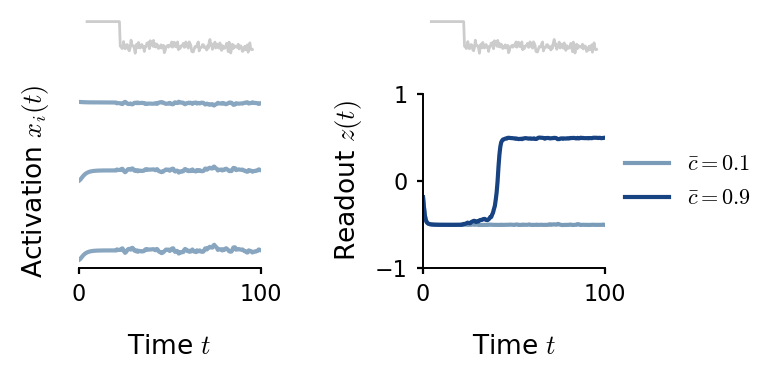

In [9]:
A_color = '#184383'
B_color = '#7B9CB8'

fig, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 5]}, figsize=(4, 2), dpi=200)
axes = ax.flatten()

for ax in axes[:2]:
    ind = 1
    ax.plot(I_timeseries[ind, :] + 0.5* noise_all[-1][0, :], c='k', alpha=0.2)
    ax.set_axis_off()
    
for ax in axes[2:]:
    ax.set_xlabel(r'Time $t$')
    ax.set_xlim(0, total_time)
    ax.set_xticklabels(['0', '100'])
    ax.locator_params(axis='x', nbins=1)

ind = 60
for i in range(3):
    axes[2].plot(activations_all[0][ind*i] - 30 - 15*i, c=B_color, alpha=0.9, lw=1.5)

axes[3].plot(readouts_all[0], c=B_color, lw=1.5, label=r'$\bar{c} = 0.1$')
axes[3].plot(readouts_all[-1], c=A_color, lw=1.5, label=r'$\bar{c} = 0.9$')
axes[2].set_yticks([])
axes[2].set_ylabel(r'Activation $x_i(t)$')
axes[3].set_ylabel(r'Readout $z(t)$', labelpad=4)
axes[3].set_ylim(-1, 1)

sns.despine(ax=axes[2], top=True, right=True, left=True, bottom=False)
sns.despine(ax=axes[3], top=True, right=True, left=False, bottom=False)
ax.legend(loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(wspace=0.4)



In [11]:
"""
Psychometric curve for coherences
"""

coherences = np.linspace(0, 1, 12)   # input strengths 
proportion_correct = []
repeats = 5

for c in coherences:
    n_correct = 0
    for r in range(repeats):
        activations, _ = simulate_noisy_current(P_tilde, I, I_timeseries, T, x0, c, sigma_noise, delta_t)
        readout = np.dot(np.tanh(activations).T, w) / N
        if readout[-1] > 0: n_correct += 1 
    proportion_correct.append(n_correct / repeats)



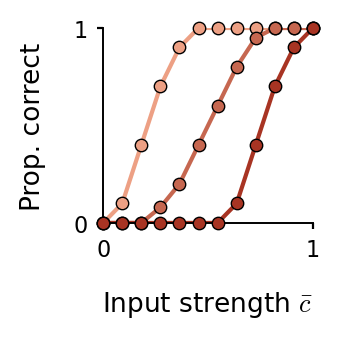

In [71]:
color1 = '#EDA084'
color2 = '#C66750'
color3 = '#A83423'

fig, ax = plt.subplots(figsize=(1.8, 1.8), dpi=200)

ax.plot(coherences, proportion_correct_50, lw=1.5, c=color1, alpha=1, label=r'60')
ax.scatter(coherences, proportion_correct_50, fc=color1, ec='black', lw=.5, s=20, zorder=3, clip_on=False)

ax.plot(coherences, proportion_correct_80, lw=1.5, c=color2, alpha=1, label=r'80')
ax.scatter(coherences, proportion_correct_80, fc=color2, ec='black', lw=.5, s=20, zorder=3, clip_on=False)

ax.plot(coherences, proportion_correct_100, lw=1.5, c=color3, alpha=1, label=r'100')
ax.scatter(coherences, proportion_correct_100, fc=color3, ec='black', lw=.5, s=20, zorder=3, clip_on=False)

ax.set_ylabel(r'Prop. correct')
ax.set_xlabel(r'Input strength $\bar{c}$')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.locator_params(axis='y', nbins=1)
plt.locator_params(axis='x', nbins=1)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()

In [12]:
"""
Variation in readout as bulk is increased 
"""

N = 2000
rho = np.sqrt(0.03)
sigma_noise = 0.4 
c = 1 
sigmas_squared = np.linspace(0.1, 1, 8)
sigmas = np.sqrt(sigmas_squared)

cutoff = 80
repeats = 20
C = 50

readout_vars_high_sparse = []

for sigma in sigmas:
    readout_var = []
    for r in range(repeats):
    
        h = np.random.normal(0, 1, N)      
        vecs = np.random.randn(3, N) 
        w, I, y = fct.orthogonal_vectors(vecs)
        I_timeseries[:, start:] = np.array([I+h]*(total_time-start)).T  

        m = np.sqrt(sigma**2 - rho**2) * w + rho * y
        n = np.sqrt(sigma**2 - rho**2) * I + rho * y
        x0 = -m-n 
        P = np.outer(m, n)
        P_tilde = fct.sparsify_columns(P, N, C)

        activations, _ = simulate_noisy_current(P_tilde, I, I_timeseries, T, x0, c, sigma_noise, delta_t)
        readout = np.dot(np.tanh(activations).T, w) / N
        
        if np.mean(readout[-cutoff:] > 0):
            readout_var.append(np.var(readout[-cutoff:]))
        
    readout_vars_high_sparse.append(np.mean(readout_var))


C = 400

readout_vars_low_sparse = []

for sigma in sigmas:
    readout_var = []
    for r in range(repeats):
        
        h = np.random.normal(0, 1, N)      
        vecs = np.random.randn(3, N) 
        w, I, y = fct.orthogonal_vectors(vecs)
        I_timeseries[:, start:] = np.array([I+h]*(total_time-start)).T  
    
        m = np.sqrt(sigma**2 - rho**2) * w + rho * y
        n = np.sqrt(sigma**2 - rho**2) * I + rho * y
        x0 = -m-n 
        P = np.outer(m, n)
        P_tilde = fct.sparsify_columns(P, N, C)

        activations, _ = simulate_noisy_current(P_tilde, I, I_timeseries, T, x0, c, sigma_noise, delta_t)
        readout = np.dot(np.tanh(activations).T, w) / N
        
        if np.mean(readout[-cutoff:] > 0):
            readout_var.append(np.var(readout[-cutoff:]))
    
    readout_vars_low_sparse.append(np.mean(readout_var))


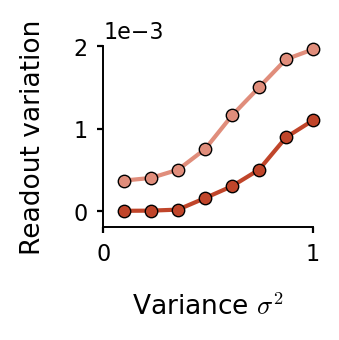

In [46]:
color = '#C0452A'
color2 = '#E08D7B'

fig, ax = plt.subplots(figsize=(1.8, 1.8), dpi=200)

ax.plot(sigmas**2, readout_vars_high_sparse, c=color2, lw=1.5, label=r'$s$ = 0.9')
ax.scatter(sigmas**2, readout_vars_high_sparse, fc=color2, ec='black', lw=.5, s=20, zorder=3, clip_on=False)
ax.plot(sigmas**2, readout_vars_low_sparse, c=color, lw=1.5, label=r'$s$ = 0.7')
ax.scatter(sigmas**2, readout_vars_low_sparse, fc=color, ec='black', lw=.5, s=20, zorder=3, clip_on=False)

ax.set_ylim([-0.0002, 0.002])
ax.set_xlim([0, 1])
ax.set_xticks([0, 1])

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_ylabel(r'Readout variation')
ax.set_xlabel(r'Variance $\sigma^2$')
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=2)
sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout()